In [17]:
"""
  INFORMATION:
  
    Course     : EEE485/585
    Name       : Can Kocagil
    ID         : 21602218
    E-mail     : can.kocagil@ug.bilkent.edu.tr
    Assignment : Progress Report

"""

from __future__ import (
    print_function,
    division
)

import matplotlib.pyplot as plt
import stopwordsiso as swiso
import seaborn as sns
import pandas as pd
import numpy as np
import cleantext
import warnings
import random
import string
import pickle
import spacy
import json
import nltk
import time
import abc
import os 
import re
import sys 
sys.path.append('./src')

from sklearn.utils.validation import (
    check_X_y, 
    check_array
)

from sklearn.metrics import (
    confusion_matrix,
    precision_score
)

from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)

from sklearn.model_selection import train_test_split

from typing import (
    Callable,
    Iterable,
    List,
    Union,
    Tuple,
)

from utils import (
    Pipeline,
    Classifier,
    json_print,
    timeit,
    random_seed
)
from classifier import (
    KNeighborsClassifier,
    MultiNominalNaiveBayes,
    BernaulliNaiveBayes,
    LogisticRegression
)

from feature import (
    BackwardElimination,
    #mutual_information
)

In [2]:
df = pd.read_parquet('../data/final_training_data.parquet')

df = df.sample(1000)

# Feature Extraction

In [3]:
doc = df['clean_freq_removed_text']

vectorizer=  TfidfVectorizer(
    #max_features = 10000,
    ngram_range = (1, 1),
    analyzer='word',
    stop_words='english',
    norm='l2'
)

vectorizer.fit(doc)

features = vectorizer.transform(doc)

In [4]:
features.shape

(1000, 888)

# Train and Test Split

In [5]:
concat_doc_count = False

if concat_doc_count:
    X = np.concatenate(
            [
                features.toarray(),
                df['doc_count_clean_freq_removed_text'].values.reshape(-1, 1)
        ],
        axis = 1
    )

else:
    X = features.toarray()
    
y = df['sentiment']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(   
    X, y,
    test_size = 0.22,
    random_state = 21
)

In [7]:
X_train  = pd.DataFrame(X_train)
X_test  = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_train.columns = ['class']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (780, 888)
X_test shape: (220, 888)
y_train shape: (780, 1)
y_test shape: (220,)


# Modelling

## Multinominal Naive Bayes

In [8]:
doc = df['clean_text']

vectorizer = CountVectorizer(
    max_features = 1000,
    ngram_range = (1, 1)
)
vectorizer.fit(doc)

features = vectorizer.transform(doc)

concat_doc_count = False

if concat_doc_count:
    X = np.concatenate(
            [
                features.toarray(),
                df['doc_count_clean_freq_removed_text'].values.reshape(-1, 1)
        ],
        axis = 1
    )

else:
    X = features.toarray()
    
y = df['sentiment']


X_train, X_test, y_train, y_test = train_test_split(   
    X, y,
    test_size = 0.22,
    random_state = 21
)

X_train  = pd.DataFrame(X_train)
X_test  = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_train.columns = ['class']
y_train = y_train.reset_index().drop('index', 1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (780, 1000)
X_test shape: (220, 1000)
y_train shape: (780, 1)
y_test shape: (220,)


/var/folders/2s/tzkz7dx17_94s45s202b6n180000gn/T/ipykernel_29830/2646091880.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  y_train = y_train.reset_index().drop('index', 1)


In [9]:
m = MultiNominalNaiveBayes().fit(X_train.values, y_train)
(m.predict(X_test) == y_test.values).mean()

Time Consumed for fit: 0.0156 s
Time Consumed for predict: 0.0191 s


/Users/cankocagil/miniforge_x86_64/lib/python3.9/site-packages/CS464_HW2-0.1-py3.9.egg/classifier.py:447: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


0.6363636363636364

Time Consumed for fit: 0.0139 s
Time Consumed for predict: 0.0008 s
Time Consumed for predict: 0.0006 s


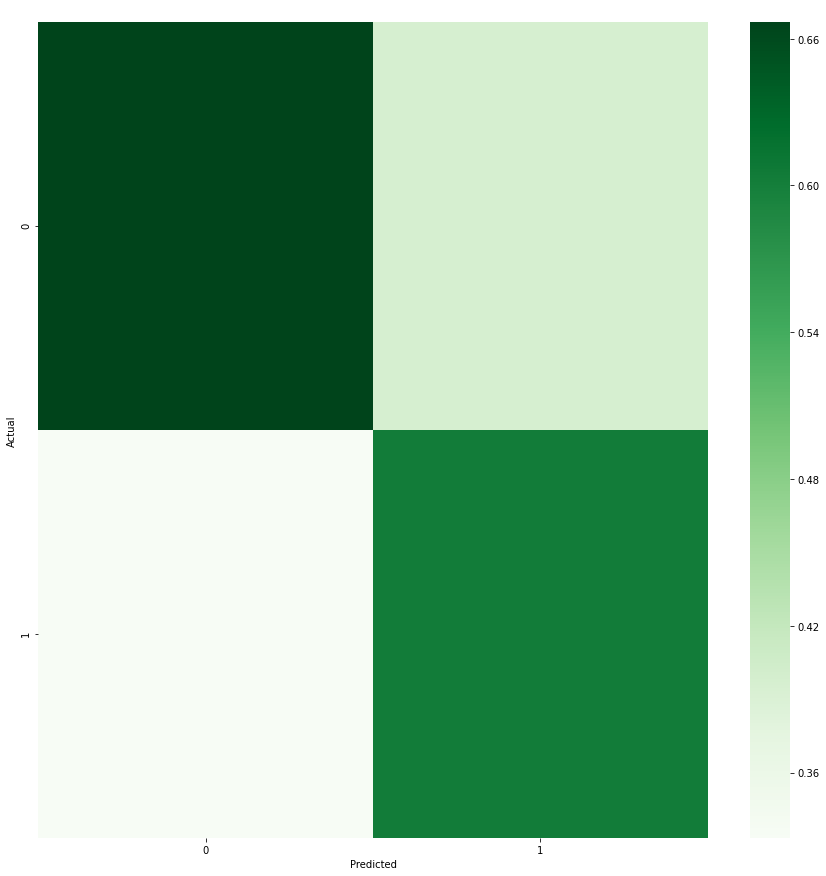

Accuracy Score: 63.63636363636363
Confusion Matrix: 
 Predicted         0         1
Actual                       
0          0.666667  0.396226
1          0.333333  0.603774
The number of parameters to be estimated: 2001


In [10]:
pipe = Pipeline([
        ('classifier', 
        MultiNominalNaiveBayes(
        )
    )
])


pipe.fit(
    X_train = X_train,
    y_train = y_train
)


score = pipe.score(
    X_test = X_test.values,
    y_test = y_test
)

predictions = pipe.predict(
    X_test = X_test.values,
)

conf_matrix = pipe.model.confusion_matrix(
    predictions.reshape(-1, ),
    y_test.values.reshape(-1, ),
)

pipe.model.visualize_confusion_matrix(conf_matrix)

print(f"Accuracy Score: {score['accuracy']}")
print(f"Confusion Matrix: \n {conf_matrix}")
print(f"The number of parameters to be estimated: {pipe.model.priors.size + pipe.model.likelihoods.size - 1}")


## Bernoulli Naive Bayes

In [12]:
pipe = Pipeline([
        ('classifier', 
        BernaulliNaiveBayes(
            alpha=0.00019
        )
    )
])


pipe.fit(
    X_train = np.where(X_train >= 1, 1, 0),
    y_train = y_train
)

score = pipe.score(
    X_test = np.where(X_test >= 1, 1, 0),
    y_test = y_test
)

conf_matrix = pipe.model.confusion_matrix(
    predictions,
    y_test.values
)

print(f"Accuracy Score: {score['accuracy']}")
print(f"Confusion Matrix: \n {conf_matrix}")

Time Consumed for fit: 0.0139 s
Time Consumed for predict: 0.0129 s
Accuracy Score: 63.18181818181819
Confusion Matrix: 
 Predicted   0   1
Actual           
0          76  42
1          38  64


/Users/cankocagil/miniforge_x86_64/lib/python3.9/site-packages/CS464_HW2-0.1-py3.9.egg/classifier.py:490: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [18]:
def mutual_information(
    x1:np.ndarray,
    x2:np.ndarray
) -> np.float:

    jh = np.histogram2d(
        x1,
        x2,
        bins = (
            256, 256
        )
    )[0]

    jh = jh + 1e-15

    sh = np.sum(jh)
    jh = jh / sh

    y1 = np.sum(
        jh,
        axis=0
    ).reshape(
        ( -1, jh.shape[0])
    )

    y2 = np.sum(
        jh,
        axis=1
    ).reshape(
        (jh.shape[1], -1)
    )


    return  ( 
        np.sum(jh * np.log(jh)) - np.sum(y1 * np.log(y1)) - np.sum(y2 * np.log(y2))
    )


In [19]:
mutual_infos = []
feature_dimension = X_train.shape[1]

for feature in range(feature_dimension):

    mutual_infos.append(
        mutual_information(
            X_train.values[:, feature].reshape(-1, ),
            y_train.values.reshape(-1, )
        )
    )  

mutual_infos = np.array(mutual_infos)


# %%
sorted_mutual_infos = np.flip(
    mutual_infos.argsort(
        axis = 0
    )
)

cache = []
selected_features = []


for iteration in range(0, 1000, 100):

    features = sorted_mutual_infos[iteration: iteration + 100]

    selected_features.extend(
        features
    )
    
    
    pipe = Pipeline([
            ('classifier', 
            BernaulliNaiveBayes(
                alpha=0.00019
            )
        )
    ])

    since = time.time()

    pipe.fit(
        X_train = np.where(X_train >= 1, 1, 0)[:, selected_features],
        y_train = y_train,
    )

    time_passed = time.time() - since

    score = pipe.score(
        X_test = np.where(X_test >= 1, 1, 0)[:, selected_features],
        y_test = y_test.values
    )

    cache.append(
        {  
            'Iter num'         : iteration,
            'Features'         : features,
            'Feature Dim'      : len(selected_features),
            'Fitting Time (s)' : round(time_passed, 4),
            'Accuracy'         : score['accuracy']
        }
        
    )

df_cache = pd.DataFrame(cache).sort_values('Accuracy', ascending = False)
df_cache['Iter num'] = (df_cache['Iter num'] / 100).astype(int)

Time Consumed for fit: 0.0035 s
Time Consumed for predict: 0.0036 s
Time Consumed for fit: 0.0035 s
Time Consumed for predict: 0.0046 s
Time Consumed for fit: 0.0037 s
Time Consumed for predict: 0.0058 s
Time Consumed for fit: 0.0044 s
Time Consumed for predict: 0.0067 s
Time Consumed for fit: 0.0063 s
Time Consumed for predict: 0.0076 s
Time Consumed for fit: 0.0071 s
Time Consumed for predict: 0.0087 s
Time Consumed for fit: 0.0071 s
Time Consumed for predict: 0.0099 s
Time Consumed for fit: 0.0089 s
Time Consumed for predict: 0.0111 s
Time Consumed for fit: 0.008 s
Time Consumed for predict: 0.0119 s
Time Consumed for fit: 0.0091 s
Time Consumed for predict: 0.0132 s


/Users/cankocagil/miniforge_x86_64/lib/python3.9/site-packages/CS464_HW2-0.1-py3.9.egg/classifier.py:490: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [20]:
df_cache

,Iter num,Features,Feature Dim,Fitting Time (s),Accuracy
5,5,"[21, 13, 729, 224, 223, 916, 389, 917, 944, 96...",600,0.0090,65.000000
6,6,"[642, 941, 981, 670, 305, 855, 361, 366, 105, ...",700,0.0092,65.000000
1,1,"[293, 124, 423, 334, 875, 85, 863, 357, 212, 7...",200,0.0048,63.181818
4,4,"[280, 749, 285, 656, 655, 286, 120, 697, 646, ...",500,0.0079,63.181818
7,7,"[235, 572, 811, 260, 315, 820, 813, 60, 550, 8...",800,0.0116,63.181818
8,8,"[807, 165, 523, 673, 170, 596, 159, 710, 154, ...",900,0.0101,63.181818
9,9,"[168, 169, 374, 584, 498, 204, 176, 396, 492, ...",1000,0.0115,63.181818
2,2,"[332, 327, 241, 246, 304, 302, 97, 702, 258, 2...",300,0.0051,62.727273
0,0,"[721, 804, 452, 592, 506, 842, 817, 121, 5, 92...",100,0.0047,62.272727
3,3,"[577, 708, 827, 84, 101, 835, 553, 832, 329, 8...",400,0.0059,61.818182


## k-Neirest Neigbhor

In [21]:
doc = df['clean_freq_removed_text']

vectorizer=  TfidfVectorizer(
    max_features = 10000,
    ngram_range = (1, 1),
    analyzer='word',
    stop_words='english',
    norm='l2'
)

vectorizer.fit(doc)

features = vectorizer.transform(doc)

concat_doc_count = False

if concat_doc_count:
    X = np.concatenate(
            [
                features.toarray(),
                df['doc_count_clean_freq_removed_text'].values.reshape(-1, 1)
        ],
        axis = 1
    )

else:
    X = features.toarray()
    
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(   
    X, y,
    test_size = 0.22,
    random_state = 21
)

X_train  = pd.DataFrame(X_train)
X_test  = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_train.columns = ['class']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (780, 888)
X_test shape: (220, 888)
y_train shape: (780, 1)
y_test shape: (220,)


In [22]:
distances = [
    'euclidean',
    'manhattan',
    'cosine'
]

k_neighbors = 7

cache_model = []

for distance in distances:
    pipe = Pipeline([
        ('classifier', 
        KNeighborsClassifier(
            k_neighbors = k_neighbors,
            distance_metric = distance
            )
        )
    ])

    pipe.fit(
        X_train = X_train.values,
        y_train = y_train.values
    )

    score = pipe.score(
        X_test = X_test.values,
        y_test = y_test.values
    )


    cache_model.append(
        (   
            pipe.model,
            pipe.model.distance_metric, 
            score['accuracy']
        )
    )

result_df = pd.DataFrame(
    cache_model,
    columns = [
        'Model',
        'Distance',
        'Accuracy'
    ]
)

result_df

,Model,Distance,Accuracy
0,K-Nearest Neighbors with hyperparameters {\n ...,euclidean,49.702479
1,K-Nearest Neighbors with hyperparameters {\n ...,manhattan,50.165289
2,K-Nearest Neighbors with hyperparameters {\n ...,cosine,49.768595


# Logistic Regression

In [24]:
class LogisticRegression(Classifier):
    def __init__(self):
        super().__init__()    

    def init_params(self,
        input_shape:int,
        output_shape:int = 1
    ):
        self.__random_seed()

        #assert self.X_train.shape[1] == self.X_test.shape[1], 'Improper feature dimension!'

        W_high = self.__init_xavier(input_shape, output_shape)
        W_low  = - W_high
        W_size = (input_shape, output_shape)
        B_size = (1, output_shape)

        self.W = np.random.uniform(
            W_low,
            W_high,
            size = W_size
        )

        self.b = np.random.uniform(
            W_low,
            W_high, 
            size = B_size
        )


    def __random_seed(self, seed = 32):
        """ Random seed for reproducebility """
        random.seed(seed)
        np.random.seed(seed)

    def __init_xavier(self, L_pre, L_post):
        """ Given the size of the input node and hidden node, initialize the weights drawn from uniform distribution ~ Uniform[- sqrt(6/(L_pre + L_post)) , sqrt(6/(L_pre + L_post))]  """    
        return np.sqrt(6/(L_pre + L_post))   

    def __train_config(self,
        lr:float,
        batch_size:int,
        epochs:int,
    ):
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs

    def sigmoid(self,X, grad = False):
        """ Computing sigmoid and it's gradient w.r.t. it's input """
        sig = 1/(1 + np.exp(-X))

        return sig * (1-sig) if grad else sig

    def __forward(self, X):

        Z = (X @ self.W)  + self.b
        A = self.sigmoid(Z)

        return {
            "Z": Z,
            "A": A
        }

    
    def __SGD(self, grads):
        self.W -= self.lr * grads['W']  
        self.b -= self.lr * grads['b']
    

    def matrix_back_prop(self, outs, X, Y):
        """ Matrix form backward propagation """
        m = self.batch_size 
            
        Z = outs['Z']
        A = outs['A']

        dZ = (A-Y) * self.sigmoid(Z, grad = True)    
        dW = (1 / m) * (X.T @ dZ)  
        db = (1 / m) * np.sum(dZ, axis=0, keepdims=True) 
        
        assert self.W.shape == dW.shape, f'Error in weight shapes!, {dW.shape} does not match with {self.W.shape}'
        assert self.b.shape == db.shape, f'Error in bias shapes!, {db.shape} does not match with {self.b.shape}'

        grads = {}
        grads['W'] = dW
        grads['b'] = db

        return grads


    def backward(self,
        outs,
        X,
        Y
    ):
        return self.matrix_back_prop(
            outs,
            X,
            Y
        )

    
    def BinaryCrossEntropyLoss(self, pred, label):        
        m = pred.shape[0]
        preds = np.clip(pred, 1e-16, 1 - 1e-16)
        loss = np.sum(-label * np.log(preds + 1e-20) - (1 - label) * np.log(1 - preds + 1e-20))        
        return loss / m 
    
    def eval(self, x, y, knob:float = 0.5):
        predictions = self.__forward(x)
        predictions = predictions['A']
        predictions[predictions>=knob] = 1
        predictions[predictions< knob] = 0
        acc_score = self.accuracy(predictions, y)

        return acc_score

    def __accuracy(self,pred,label):
        return np.sum(pred == label) / pred.shape[0]


    @timeit
    def fit(
        self, 
        X_train,
        y_train,
        X_test,
        y_test, 
        lr:float = 1e-2, 
        batch_size:int = 32,
        epochs:int = 100, 
        verbose = True
    ):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """

        self.init_params(
            input_shape = X_train.shape[1]
            )

        self.__train_config(
            lr,
            batch_size,
            epochs,
        )

        self.history = {}

        self.history['train'] = {
            'loss': [],
            'acc' : []
        }

        self.history['val'] =   {
            'loss': [],
            'acc' : []
        }
        
        m = self.batch_size
        
        self.sample_size_train = X_train.shape[0]
        
        for epoch in range(self.epochs):

            perm = np.random.permutation(self.sample_size_train)          
            
            for i in range(self.sample_size_train // m):
                

                shuffled_index = perm[i*m: (i+1)*m]
                
                X_feed = X_train[shuffled_index]    
                y_feed = y_train[shuffled_index]
                                
                outs = self.__forward(X_feed)              
                grads = self.backward(
                    outs,
                    X_feed,
                    y_feed
                )
                self.__SGD(grads)

            loss_train = self.BinaryCrossEntropyLoss(
                self.__forward(X_train)['A'],
                y_train
            )     

            acc_train = self.eval(
                X_train,
                y_train
            )   

            self.history['train']['loss'].append(loss_train)
            self.history['train']['acc'].append(acc_train)
                
            
                
            loss_val = self.BinaryCrossEntropyLoss(
                self.__forward(X_test)['A'],
                y_test
            )     

            acc_val  = self.eval(
                X_test,
                y_test
            )             

            self.history['val']['loss'].append(loss_val)
            self.history['val']['acc'].append(acc_val)

            if verbose:                    
                print(f"[{epoch}/{self.epochs}] ------> Training : BCE: {loss_train} and Acc: {acc_train}")                       
                print(f"[{epoch}/{self.epochs}] ------> Testing  : BCE: {loss_val}   and  Acc: {acc_val}")


    def __str__(self):
        model = LogisticRegression().__class__.__name__
        model += f' with hyperparameters (learning rate,batch_size,epochs) = ({self.lr,self.batch_size,self.epochs})'
        num_params = self.W.shape[0] * self.W.shape[1] + self.b.shape[0] * self.b.shape[1]
        model += f'\n There are {num_params} number of traniable parameters'
        return model

    def __repr__(self):
        model = LogisticRegression().__class__.__name__    
        model += f' with hyperparameters (learning rate,batch_size,epochs) = ({self.lr,self.batch_size,self.epochs})'
        num_params = self.W.shape[0] * self.W.shape[1] + self.b.shape[0] * self.b.shape[1]
        model += f'\n There are {num_params} number of traniable parameters'
        return model

    def plot_history(self):

        fig,axs = plt.subplots(1,2,figsize = (24,8))
        axs[0].plot(self.history['train']['loss'],color = 'orange',label = 'Training')
        axs[0].plot(self.history['val']['loss'], label = 'Validation')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('BCE Loss')
        axs[0].set_title(f'Binary Cross Entropy Loss Over Iterations with Learning Rate $\eta$ = {self.lr}')
        axs[0].legend(loc="upper right")  
        axs[0].grid()

        axs[1].plot(self.history['train']['acc'],color ='orange',label = 'Training')
        axs[1].plot(self.history['val']['acc'], label = 'Validation')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        maxs = round(max(self.history['train']['acc']),3), round(max(self.history['val']['acc']),3)
        axs[1].set_title(f'Accuracy Over Iterations with Learning Rate $\eta$ =  {self.lr} \n Best Accuracy in (Training,Validation) = {maxs} ')
        axs[1].legend(loc="lower right")   
        axs[1].grid()

Time Consumed for fit: 2.0937 s
LogisticRegression with hyperparameters (learning rate,batch_size,epochs) = ((0.001, 64, 1000))
 There are 889 number of traniable parameters


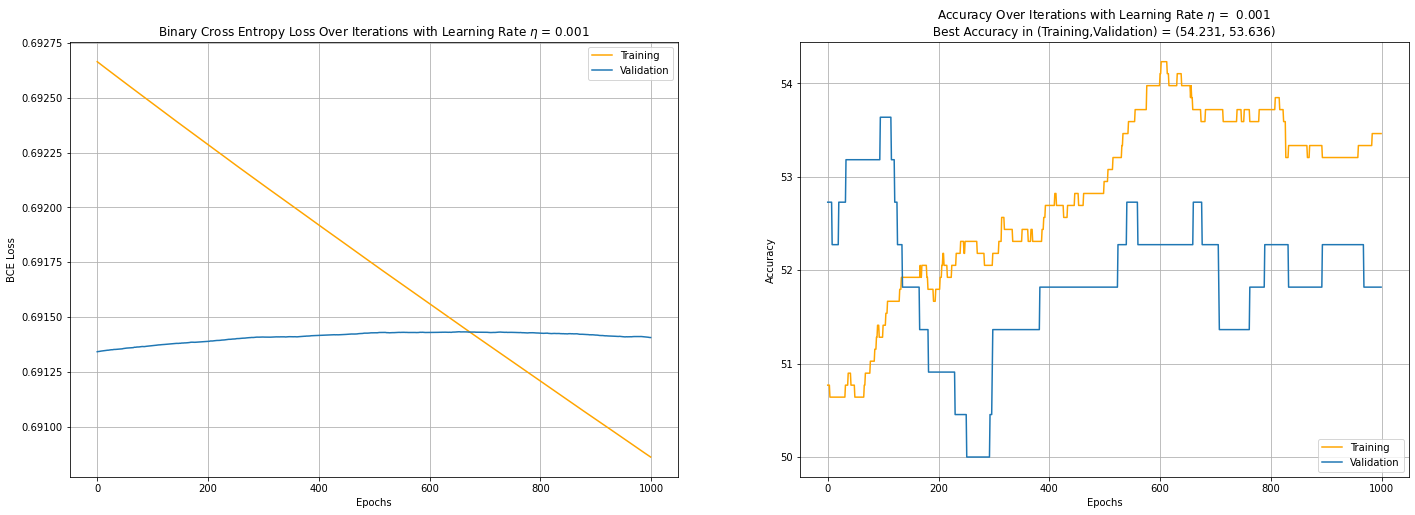

In [25]:
train_config = dict(
    lr          = 1e-3,
    batch_size  = 64,
    epochs      = 1000,
    verbose = False,
)

model = LogisticRegression()
model.fit(
    X_train.values,
    y_train.values.reshape(-1, 1),
    X_test.values,
    y_test.values.reshape(-1, 1),
    **train_config
)
model.plot_history()
print(model)

Time Consumed for fit: 32m 31s
LogisticRegression with hyperparameters (learning rate,batch_size,epochs) = ((0.001, 64, 100000))
 There are 1028 number of traniable parameters


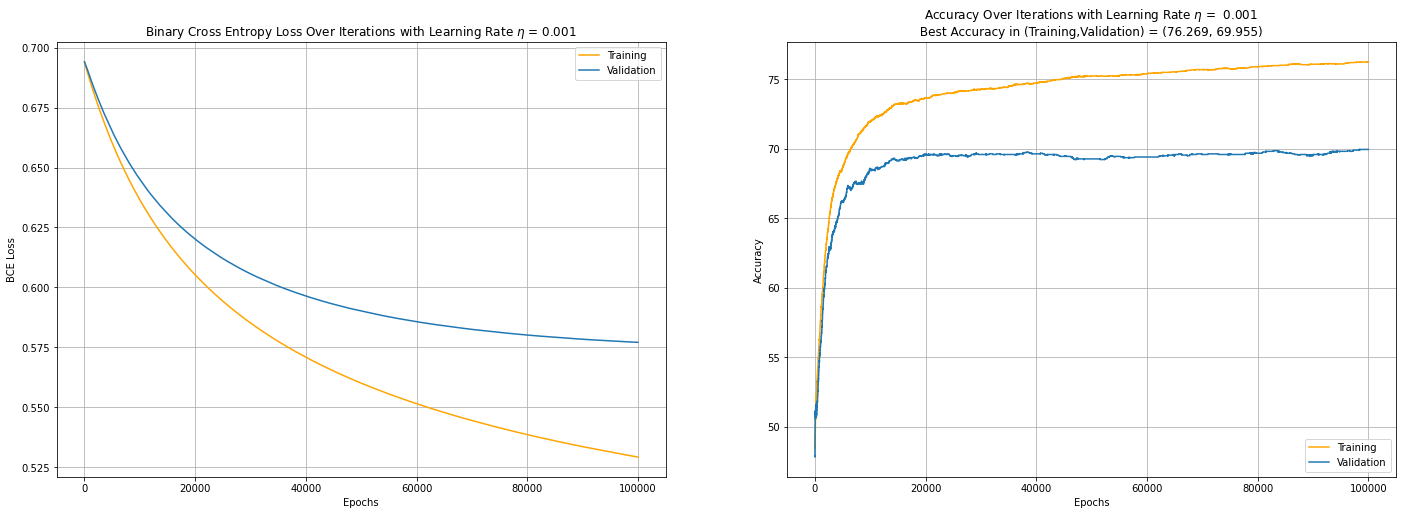

In [ ]:
train_config = dict(
    lr          = 1e-3,
    batch_size  = 64,
    epochs      = 100000,
    verbose = False,
)

model = LogisticRegression()
model.fit(
    X_train.values,
    y_train.values.reshape(-1, 1),
    X_test.values,
    y_test.values.reshape(-1, 1),
    **train_config
)
model.plot_history()
print(model)

Time Consumed for fit: 2m 53s
LogisticRegression with hyperparameters (learning rate,batch_size,epochs) = ((0.009, 128, 10000))
 There are 1028 number of traniable parameters


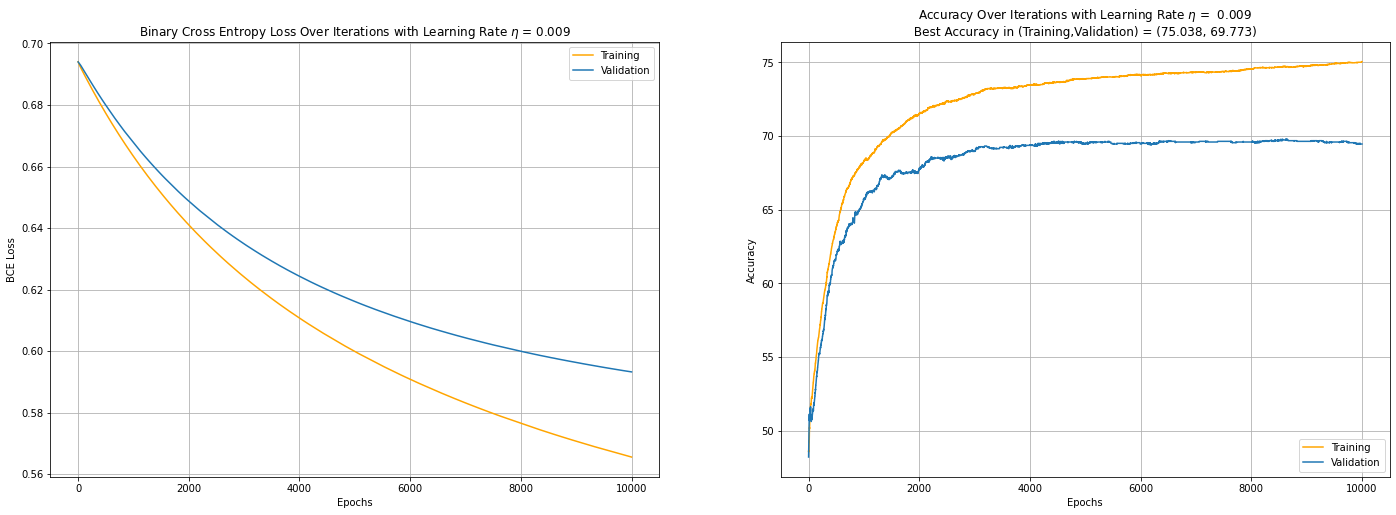

In [ ]:
train_config = dict(
    lr          = 9e-3,
    batch_size  = 128,
    epochs      = 10000,
    verbose = False,
)

model = LogisticRegression()
model.fit(
    X_train.values,
    y_train.values.reshape(-1, 1),
    X_test.values,
    y_test.values.reshape(-1, 1),
    **train_config
)
model.plot_history()
print(model)